# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## AT LAST - it's time for Fine Tuning!

After all this data preparation, and old school machine learning, we've finally arrived at the moment you've been waiting for. Fine-tuning a model.

In [2]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [3]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from items import Item
from testing import Tester

In [6]:
openai = OpenAI()

In [7]:
%matplotlib inline

In [8]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [9]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 200 examples (and 1 epoch)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

# Step 1

Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [10]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [11]:
messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7'},
 {'role': 'assistant', 'content': 'Price is $226.95'}]

In [12]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [13]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7"}, {"role": "assistant", "content": "Price is $226.95"}]}
{"messages": [{"role": "system", "content": "You estimate prices of items. 

In [14]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [15]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [16]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [18]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [19]:
train_file

FileObject(id='file-FGMsosPoJtU3oCAXrQpiT3', bytes=188543, created_at=1748091968, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [20]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [21]:
validation_file

FileObject(id='file-HUwpRLdnfJsZ1prZmXPBEz', bytes=47036, created_at=1748092019, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

# Step 2

I love Weights and Biases - a beautiful, free platform for monitoring training runs.  
Weights and Biases is integrated with OpenAI for fine-tuning.

First set up your weights & biases free account at:

https://wandb.ai

From the Avatar >> Settings menu, near the bottom, you can create an API key.

Then visit the OpenAI dashboard at:

https://platform.openai.com/account/organization

In the integrations section, you can add your Weights & Biases key.

## And now time to Fine-tune!

In [22]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [23]:
train_file.id

'file-FGMsosPoJtU3oCAXrQpiT3'

In [25]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-msJuvUMDoDmGLIlD7nHShpRp', created_at=1748092357, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-OaYfZSA9AAn0uB20C8sZ0alh', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-FGMsosPoJtU3oCAXrQpiT3', validation_file='file-HUwpRLdnfJsZ1prZmXPBEz', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-msJuvUMDoDmGLIlD7nHShpRp'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer', usage_metr

In [26]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-msJuvUMDoDmGLIlD7nHShpRp', created_at=1748092357, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-OaYfZSA9AAn0uB20C8sZ0alh', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-FGMsosPoJtU3oCAXrQpiT3', validation_file='file-HUwpRLdnfJsZ1prZmXPBEz', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-msJuvUMDoDmGLIlD7nHShpRp'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_

In [27]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [28]:
job_id

'ftjob-msJuvUMDoDmGLIlD7nHShpRp'

In [29]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-msJuvUMDoDmGLIlD7nHShpRp', created_at=1748092357, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-OaYfZSA9AAn0uB20C8sZ0alh', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-FGMsosPoJtU3oCAXrQpiT3', validation_file='file-HUwpRLdnfJsZ1prZmXPBEz', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-msJuvUMDoDmGLIlD7nHShpRp'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix='pricer', usage_metrics=None, shared

In [31]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-Os0lhOq1So8lNht2rNBl6r8v', created_at=1748093764, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-ssTUXnCfErN0cPi7fAYEXAr8', created_at=1748093761, level='info', message='Usage policy evaluations completed, model is now enabled for sampling', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-wPZqquhsh1F7gh6NkNZWSBv7', created_at=1748093001, level='info', message='Evaluating model against our usage policies before enabling', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-muYA7FmZZjuGRcqenBe52MXT', created_at=1748093001, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-mUdQXyOPzaGDOwEP4FSbblNX', created_at=1748092939, level='info', message='Step 200/200: training loss=1.13, validat

# Step 3

Test our fine tuned model

In [32]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [33]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:Baj8KXfR'

In [34]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [35]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [36]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [37]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [38]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [39]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

374.41
490.0


In [40]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $


1: Guess: $490.00 Truth: $374.41 Error: $115.59 SLE: 0.07 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $194.99 Truth: $225.11 Error: $30.12 SLE: 0.02 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $65.65 Truth: $61.68 Error: $3.97 SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $499.98 Truth: $599.99 Error: $100.01 SLE: 0.03 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $14.65 Truth: $16.99 Error: $2.34 SLE: 0.02 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $13.66 Truth: $31.99 Error: $18.33 SLE: 0.66 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $139.98 Truth: $101.79 Error: $38.19 SLE: 0.10 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $262.47 Truth: $289.00 Error: $26.53 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $349.99 Truth: $635.86 Error: $285.87 SLE: 0.35 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $127.99 Truth: $65.99 Error: $62.00 SLE: 0.43 

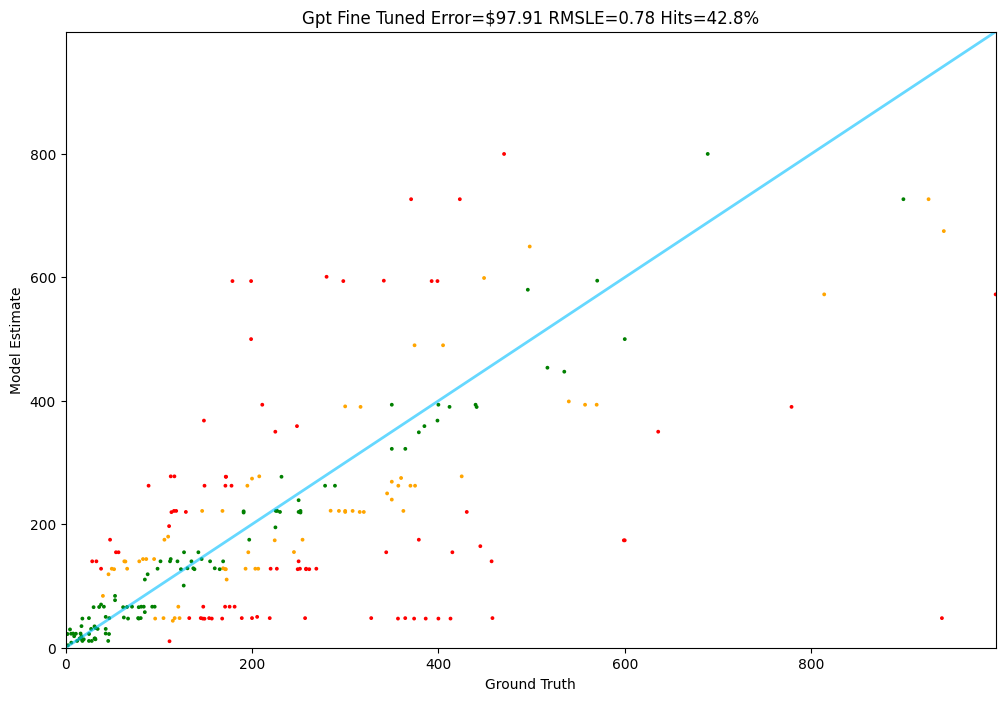

In [41]:
Tester.test(gpt_fine_tuned, test)